<a href="https://colab.research.google.com/github/emilianodesu/SIAFI-2026-1/blob/main/DL/3_1_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# 3. Deep Learning

## 3.1 Fundamentals for Training Models

### 3.1.1 Gradient Descent

*Gradient descent* is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of gradient descent is to tweak parameters iteratively in order to minimize a cost function.

Suppose you are lost in the mountains in a dense fog, and you can only feel the slope of the ground below your feet. A good strategy to get to the bottom of the valley quickly is to go downhill in the direction of the steepest slope. This is exactly what gradient descent does: it measures the local gradient of the error function with regard to the parameter vector $\theta$, and it goes in the direction of descending gradient. Once the gradient is zero, you have reached a minimum!

In practice, you start by filling $\theta$ with random values (this is called random initialization). Then you improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function (e.g., the MSE), until the algorithm converges to a minimum.

![Gradient Descent](./img/gradient_descent.png)

An important parameter in gradient descent is the size of the steps, determined by the *learning rate* hyperparameter. If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time.

![Learning rate too small](./img/lr.png)

On the other hand, if the learning rate is too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before. This might make the algorithm diverge, with larger and larger values, failing to find a good solution.

![Learning rate too high](./img/lr2.png)

Additionally, not all cost functions look like nice, regular bowls. There may be holes, ridges, plateaus, and all sorts of irregular terrain, making convergence to the minimum difficult. If the random initialization starts the algorithm on the left, then it will converge to a local minimum, which is not as good as the global minimum. If it starts on the right, then it will take a very long time to cross the plateau. And if you stop too early, you will never reach the global minimum.

![Gradient descent pitfalls](./img/gd2.png)

Fortunately, in the case of linear regression models, the MSE cost function happens to be a *convex function*, which means that if you pick any two points on the curve, the line segment joining them is never below the curve. This implies that there are no local minima, just one global minimum. It is also a continuous function with a slope that never changes abruptly. These two facts have a great consequence: gradient descent is guaranteed to approach arbitrarily closely the global minimum (if you wait long enough and if the learning rate is not too high).

While the cost function has the shape of a bowl, it can be an elongated bowl if the features have very different scales. The next figure shows gradient descent on a training set where features 1 and 2 have the same scale (on the left), and on a training set where feature 1 has much smaller values than feature 2 (on the right).⁠

As you can see, on the left the gradient descent algorithm goes straight toward the minimum, thereby reaching it quickly, whereas on the right it first goes in a direction almost orthogonal to the direction of the global minimum, and it ends with a long march down an almost flat valley. It will eventually reach the minimum, but it will take a long time.

![Gradient descent with (left) and without (right) feature scaling](./img/gd3.png)

This diagram also illustrates the fact that training a model means searching for a combination of model parameters that minimizes a cost function (over the training set). It is a search in the model’s *parameter space*. The more parameters a model has, the more dimensions this space has, and the harder the search is: searching for a needle in a 300-dimensional haystack is much trickier than in 3 dimensions. Fortunately, since the cost function is convex in the case of linear regression, the needle is simply at the bottom of the bowl.

**Warning**: When using gradient descent, you should ensure that all features have a similar scale (e.g., using Scikit-Learn’s `StandardScaler` class), or else it will take much longer to converge.

#### 3.1.1.1 Batch Gradient Descent

Most models have more than one model parameter. Therefore, to implement gradient descent, you need to compute the gradient of the cost function with regard to each model parameter $\theta_j$. In other words, you need to calculate how much the cost function will change if you change $\theta_j$ just a little bit. This is called a *partial derivative*. It is like asking, “What is the slope of the mountain toward the east?” and then asking the same question facing north (and so on for all other dimensions, if you can imagine a universe with more than three dimensions). The following equation computes the partial derivative of the MSE with regard to parameter $\theta_j$.

**Equation 1: Partial Derivative of the cost function (MSE)**

$$\frac{\partial}{\partial \theta_j} \text{MSE} (\theta) = \frac{2}{m} \sum_{i=1}^m \left(\theta^T \mathbf{x}^{(i)} - y^{(i)}\right) x_j^{(i)}$$

Instead of computing these partial derivatives individually, you can use the next equation to compute them all in one go. The gradient vector, denoted $\nabla_\theta \text{MSE} (\theta)$, contains all the partial derivatives of the cost function (one for each model parameter).

**Equation 2: Gradient vector of the cost function (MSE)**

$$\nabla_\theta \text{MSE} (\theta) = \left ( \frac{\partial}{\partial \theta_0} \text{MSE} (\theta), \frac{\partial}{\partial \theta_1} \text{MSE} (\theta), \ldots, \frac{\partial}{\partial \theta_n} \text{MSE} (\theta) \right ) = \frac{2}{m} \mathbf{X}^T (\mathbf{X} \theta - \mathbf{y})$$

**Warning**: Notice that this formula involves calculations over the full training set $\mathbf{X}$, at each gradient descent step! This is why the algorithm is called *batch gradient descent*: it uses the whole batch of training data at every step (actually, *full gradient descent* would probably be a better name). As a result, it is terribly slow on very large training sets (we will look at some much faster gradient descent algorithms shortly). However, gradient descent scales well with the number of features; training a linear regression model when there are hundreds of thousands of features is much faster using gradient descent than using the normal equation or SVD decomposition.

Once you have the gradient vector, which points uphill, just go in the opposite direction to go downhill. This means subtracting $\nabla_\theta \text{MSE} (\theta)$ from $\theta$. This is where the learning rate $\eta$ comes into play: multiply the gradient vector by $\eta$ to determine the size of the downhill step.

**Equation 3: Gradient Descent Step**
$$\theta^{\text{(next step)}} = \theta - \eta \nabla_\theta \text{MSE} (\theta)$$

Let’s look at a quick implementation of this algorithm:

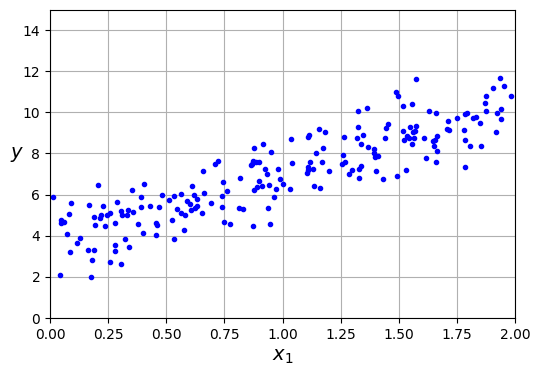

In [2]:
import numpy as np
from sklearn.preprocessing import add_dummy_feature

rng = np.random.default_rng(seed=42)
m = 200  # number of instances
X = 2 * rng.random((m, 1))  # column vector
y = 4 + 3 * X + rng.standard_normal((m, 1))  # column vector

X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis((0, 2, 0, 15))
plt.grid()

plt.show()

In [3]:
eta = 0.1  # learning rate
n_epochs = 1000
theta = rng.standard_normal((2, 1))  # randomly initialized model parameters

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

That wasn’t too hard! Each iteration over the training set is called an epoch. Let’s look at the resulting `theta`:

In [4]:
theta

array([[3.69084138],
       [3.32960458]])

Gradient descent worked perfectly. But what if you had used a different learning rate (`eta`)? Let's see the first 20 steps of gradient descent using three different learning rates. The line at the bottom of each plot represents the random starting point, then each epoch is represented by a darker and darker line.

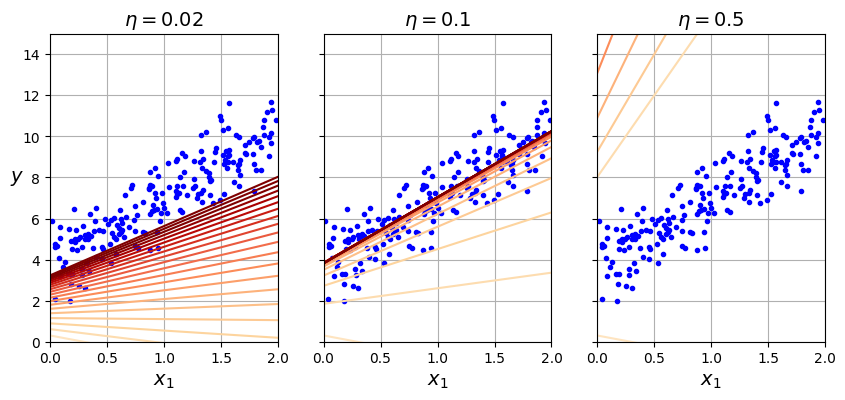

In [5]:
import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis((0, 2, 0, 15))
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

rng = np.random.default_rng(seed=42)
theta = rng.standard_normal((2, 1))  # randomly initialized model parameters

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)

plt.show()

On the left, the learning rate is too low: the algorithm will eventually reach the solution, but it will take a long time. In the middle, the learning rate looks pretty good: in just a few epochs, it has already converged to the solution. On the right, the learning rate is too high: the algorithm diverges, jumping all over the place and actually getting further and further away from the solution at every step.

To find a good learning rate, you can use grid search. However, you may want to limit the number of epochs so that grid search can eliminate models that take too long to converge.

You may wonder how to set the number of epochs. If it is too low, you will still be far away from the optimal solution when the algorithm stops; but if it is too high, you will waste time while the model parameters do not change anymore. A simple solution is to set a very large number of epochs but to interrupt the algorithm when the gradient vector becomes tiny—that is, when its norm becomes smaller than a tiny number $\epsilon$ (called the *tolerance*)—because this happens when gradient descent has (almost) reached the minimum.

**Convergence rate**: When the cost function is convex and its slope does not change abruptly (as is the case for the MSE cost function), batch gradient descent with a fixed learning rate will eventually converge to the optimal solution, but you may have to wait a while: it can take $O(1/\epsilon)$ iterations to reach the optimum within a range of $\epsilon$, depending on the shape of the cost function. If you divide the tolerance by 10 to have a more precise solution, then the algorithm may have to run about 10 times longer.

#### 3.1.1.2 Stochastic Gradient Descent

The main problem with batch gradient descent is the fact that it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large. At the opposite extreme, *stochastic gradient* descent picks a random instance in the training set at every step and computes the gradients based only on that single instance. Obviously, working on a single instance at a time makes the algorithm much faster because it has very little data to manipulate at every iteration. It also makes it possible to train on huge training sets, since only one instance needs to be in memory at each iteration (stochastic GD can be implemented as an out-of-core algorithm).

On the other hand, due to its stochastic (i.e., random) nature, this algorithm is much less regular than batch gradient descent: instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average. Over time it will end up very close to the minimum, but once it gets there it will continue to bounce around, never settling down. Once the algorithm stops, the final parameter values will be good, but not optimal.

When the cost function is very irregular, this can actually help the algorithm jump out of local minima, so stochastic gradient descent has a better chance of finding the global minimum than batch gradient descent does.

Therefore, randomness is good to escape from local optima, but bad because it means that the algorithm can never settle at the minimum. One solution to this dilemma is to gradually reduce the learning rate. The steps start out large (which helps make quick progress and escape local minima), then get smaller and smaller, allowing the algorithm to settle at the global minimum. The function that determines the learning rate at each iteration is called the *learning schedule*. If the learning rate is reduced too quickly, you may get stuck in a local minimum, or even end up frozen halfway to the minimum. If the learning rate is reduced too slowly, you may jump around the minimum for a long time and end up with a suboptimal solution if you halt training too early.

![With stochastic gradient descent, each training step is much faster but also much more stochastic than when using batch gradient descent](./img/sgd.png)

This code implements stochastic gradient descent using a simple learning schedule:

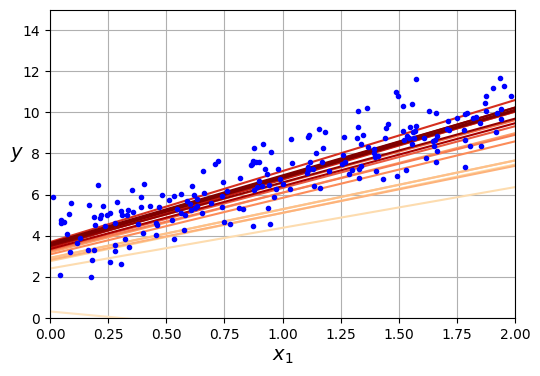

In [6]:
theta_path_sgd = [] 
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

rng = np.random.default_rng(seed=42)
theta = rng.standard_normal((2, 1))  # randomly initialized model parameters

n_shown = 20  # extra code – just needed to generate the figure below
plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting

for epoch in range(n_epochs):
    for iteration in range(m):

        # extra code – these 4 lines are used to generate the figure
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = rng.integers(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)  # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)  # learning rate
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)  # extra code – to generate the figure

# extra code – this section beautifies Figure 4–10
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis((0, 2, 0, 15))
plt.grid()

plt.show()

By convention we iterate by rounds of $m$ iterations; each round is called an *epoch*, as earlier. While the batch gradient descent code iterated 1,000 times through the whole training set, this code goes through the training set only 50 times and reaches a pretty good solution:

In [7]:
theta

array([[3.69826475],
       [3.30748311]])

Note that since instances are picked randomly, some instances may be picked several times per epoch, while others may not be picked at all. If you want to be sure that the algorithm goes through every instance at each epoch, another approach is to shuffle the training set (making sure to shuffle the input features and the labels jointly), then go through it instance by instance, then shuffle it again, and so on. However, this approach is more complex, and it generally does not improve the result.

**Warning**: When using stochastic gradient descent, the training instances must be independent and identically distributed (IID) to ensure that the parameters get pulled toward the global optimum, on average. A simple way to ensure this is to shuffle the instances during training (e.g., pick each instance randomly, or shuffle the training set at the beginning of each epoch). If you do not shuffle the instances—for example, if the instances are sorted by label—then SGD will start by optimizing for one label, then the next, and so on, and it will not settle close to the global minimum.

#### 3.1.1.3 Mini-batch Gradient Descent

The last gradient descent algorithm we will look at is called *mini-batch gradient descent*. It is straightforward once you know batch and stochastic gradient descent: at each step, instead of computing the gradients based on the full training set (as in batch GD) or based on just one instance (as in stochastic GD), mini-batch GD computes the gradients on small random sets of instances called *mini-batches*. The main advantage of mini-batch GD over stochastic GD is that you can get a performance boost from hardware acceleration of matrix operations, especially when using *graphical processing units* (GPUs).

The algorithm’s progress in parameter space is less erratic than with stochastic GD, especially with fairly large mini-batches. As a result, mini-batch GD will end up walking around a bit closer to the minimum than stochastic GD—but it may be harder for it to escape from local minima (in the case of problems that suffer from local minima, unlike linear regression with the MSE cost function). The next plot shows the paths taken by the three gradient descent algorithms in parameter space during training. They all end up near the minimum, but batch GD’s path actually stops at the minimum, while both stochastic GD and mini-batch GD continue to walk around. However, don’t forget that batch GD takes a lot of time to take each step, and stochastic GD and mini-batch GD would also reach the minimum if you used a good learning schedule.

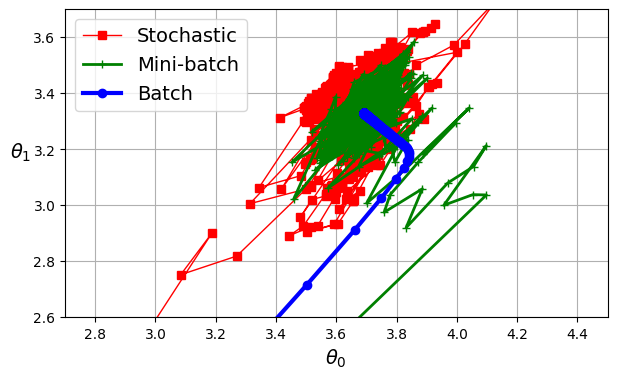

In [8]:
from math import ceil

n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

rng = np.random.default_rng(seed=42)
theta = rng.standard_normal((2, 1))  # randomly initialized model parameters

t0, t1 = 200, 1000  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta_path_mgd = []
for epoch in range(n_epochs):
    shuffled_indices = rng.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for iteration in range(0, n_batches_per_epoch):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx : idx + minibatch_size]
        yi = y_shuffled[idx : idx + minibatch_size]
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(epoch * n_batches_per_epoch + iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1,
         label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2,
         label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3,
         label="Batch")
plt.legend(loc="upper left")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$   ", rotation=0)
plt.axis((2.7, 4.5, 2.6, 3.7))
plt.grid()

plt.show()

### 3.1.2 Learning curves

In the Machine Learning Course you have used cross-validation to get an estimate of a model’s generalization performance. If a model performs well on the training data but generalizes poorly according to the cross-validation metrics, then your model is overfitting. If it performs poorly on both, then it is underfitting. This is one way to tell when a model is too simple or too complex.

Another way to tell is to look at the learning curves, which are plots of the model’s training error and validation error as a function of the training iteration: just evaluate the model at regular intervals during training on both the training set and the validation set, and plot the results. If the model cannot be trained incrementally (i.e., if it does not support `partial_fit()` or `warm_start`), then you must train it several times on gradually larger subsets of the training set.

Scikit-Learn has a useful `learning_curve()` function to help with this: it trains and evaluates the model using cross-validation. By default it retrains the model on growing subsets of the training set, but if the model supports incremental learning you can set `exploit_incremental_learning=True` when calling `learning_curve()` and it will train the model incrementally instead. The function returns the training set sizes at which it evaluated the model, and the training and validation scores it measured for each size and for each cross-validation fold. Let’s use this function to look at the learning curves of the plain linear regression model.

In [9]:
rng = np.random.default_rng(seed=42)
m = 200  # number of instances
X = 6 * rng.random((m, 1)) - 3
y = 0.5 * X ** 2 + X + 2 + rng.standard_normal((m, 1))

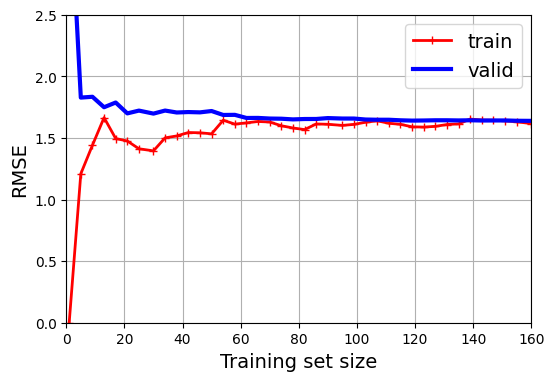

In [10]:
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis((0, 160, 0, 2.5))

plt.show()

This model is underfitting, it’s too simple for the data. How can we tell? Well, let’s look at the training error. When there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts at zero. But as new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly, both because the data is noisy and because it is not linear at all. So the error on the training data goes up until it reaches a plateau, at which point adding new instances to the training set doesn’t make the average error much better or worse. Now let’s look at the validation error. When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite large. Then, as the model is shown more training examples, it learns, and thus the validation error slowly goes down. However, once again a straight line cannot do a good job of modeling the data, so the error ends up at a plateau, very close to the other curve.

These learning curves are typical of a model that’s underfitting. Both curves have reached a plateau; they are close and fairly high.

**Tip**: If your model is underfitting the training data, adding more training examples will not help. You need to use a better model or come up with better features.

Now let’s look at the learning curves of a 10th-degree polynomial model on the same data 

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

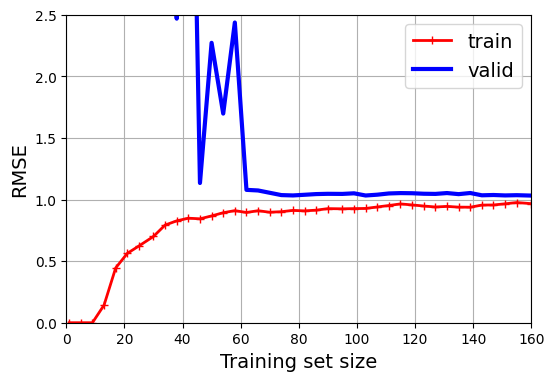

In [12]:
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis((0, 160, 0, 2.5))

plt.show()

These learning curves look a bit like the previous ones, but there are two very important differences:

* The error on the training data is much lower than before.

* There is a gap between the curves. This means that the model performs better on the training data than on the validation data, which is the hallmark of an overfitting model. If you used a much larger training set, however, the two curves would continue to get closer.

#### 3.1.2.1 The bias-variance tradeoff

An important theoretical result of statistics and machine learning is the fact that a model’s generalization error can be expressed as the sum of three very different errors:

* **Bias**: This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.

* **Variance**: This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance and thus overfit the training data.

* **Irreducible error**: This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).

Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity (or increasing regularization) increases its bias and reduces its variance. This is why it is called a trade-off.

![Bias/variance tradeoff](./img/bias.png)

**Tip**: One way to improve an overfitting model is to feed it more training data until the validation error gets close enough to the training error.

#### 3.1.2.2 Early stopping

A way to regularize iterative learning algorithms such as gradient descent is to stop training as soon as the validation error reaches a minimum. This popular technique is called *early stopping*. The next figure shows a complex model (in this case, a high-degree polynomial regression model) being trained with batch gradient descent on the quadratic dataset we used earlier. As the epochs go by, the algorithm learns, and its prediction error (RMSE) on the training set goes down, along with its prediction error on the validation set. After a while, though, the validation error stops decreasing and starts to go back up. This indicates that the model has started to overfit the training data. With early stopping you just stop training as soon as the validation error reaches the minimum. That said, the validation error sometimes comes back down after a while: this is called *double descent*. It’s fairly common with large neural networks, and is an area of active research.

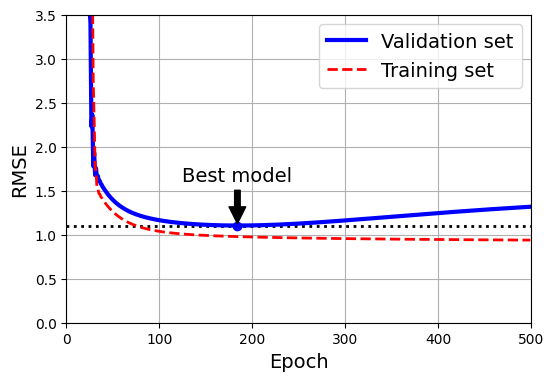

In [13]:
from copy import deepcopy
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

# extra code – creates the same quadratic dataset as earlier and splits it
rng = np.random.default_rng(seed=42)
m = 200  # number of instances
X = 6 * rng.random((m, 1)) - 3
y = 0.5 * X ** 2 + X + 2 + rng.standard_normal((m, 1))
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []  # extra code – it's for the figure below

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = root_mean_squared_error(y_valid, y_valid_predict)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    # extra code – we evaluate the train error and save it for the figure
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = root_mean_squared_error(y_train, y_train_predict)
    val_errors.append(val_error)
    train_errors.append(train_error)

# extra code – this section generates Figure 4–20
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis((0, n_epochs, 0, 3.5))
plt.grid()

plt.show()

**Tip**: With stochastic and mini-batch gradient descent, the curves are not so smooth, and it may be hard to know whether you have reached the minimum or not. One solution is to stop only after the validation error has been above the minimum for some time (when you are confident that the model will not do any better), then roll back the model parameters to the point where the validation error was at a minimum.

Here is a basic implementation of early stopping:

```python
from copy import deepcopy
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

X_train, y_train, X_valid, y_valid = [...]  # split the dataset

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False), StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = root_mean_squared_error(y_valid, y_valid_predict)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)
```

This code first adds the polynomial features and scales all the input features, both for the training set and for the validation set (the code assumes that you have split the original training set into a smaller training set and a validation set). Then it creates an `SGDRegressor` model with no regularization and a small learning rate. In the training loop, it calls `partial_fit()` instead of `fit()`, to perform incremental learning. At each epoch, it measures the RMSE on the validation set. If it is lower than the lowest RMSE seen so far, it saves a copy of the model in the `best_model` variable. This implementation does not actually stop training, but it lets you revert to the best model after training. Note that the model is copied using `copy.deepcopy()`, because it copies both the model’s hyperparameters and the learned parameters. In contrast, `sklearn.base.clone()` only copies the model’s hyperparameters.

### 3.1.3 Logistic Regression

*Logistic regression* (also called *logit regression*) is commonly used to estimate the probability that an instance belongs to a particular class (e.g., what is the probability that this email is spam?). If the estimated probability is greater than a given threshold (typically 50%), then the model predicts that the instance belongs to that class (called the *positive class*, labeled “1”), and otherwise it predicts that it does not (i.e., it belongs to the *negative class*, labeled “0”). This makes it a binary classifier.

#### 3.1.3.1 Estimating probabilities

So how does logistic regression work? Just like a linear regression model, a logistic regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the linear regression model does, it outputs the logistic of this result.

**Equation 4: Logistic regression model estimated probability (vectorized form)**

$$\hat{p} = h_\theta(\mathbf{x}) = \sigma(\theta^T \mathbf{x})$$

The logistic—denoted $\sigma(\cdot)$—is a sigmoid function (i.e., S-shaped) that outputs a number between 0 and 1.

**Equation 5: Logistic function**

$$\sigma(t) = \frac{1}{1 + e^{-t}}$$

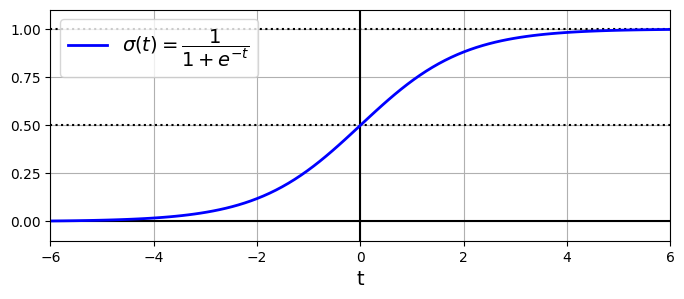

In [14]:
lim = 6
t = np.linspace(-lim, lim, 100)
sig = 1 / (1 + np.exp(-t))

plt.figure(figsize=(8, 3))
plt.plot([-lim, lim], [0, 0], "k-")
plt.plot([-lim, lim], [0.5, 0.5], "k:")
plt.plot([-lim, lim], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \dfrac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left")
plt.axis([-lim, lim, -0.1, 1.1])
plt.gca().set_yticks([0, 0.25, 0.5, 0.75, 1])
plt.grid()

plt.show()

Once the logistic regression model has estimated the probability $\hat{p} = h_\theta(\mathbf{x}) = \sigma(\theta^T \mathbf{x})$ that an instance $\mathbf{x}$ belongs to the positive class, it can make its prediction $\hat{y}$ easily by applying a threshold, typically 0.5:

**Equation 6: Logistic regression model prediction using a threshold of 0.5**:

$$\hat{y} = \begin{cases} 1 & \text{if } \hat{p} \geq 0.5 \\ 0 & \text{if } \hat{p} < 0.5 \end{cases}$$

Notice that $\sigma(t) < 0.5$ when $t < 0$, and $\sigma(t) \geq 0.5$ when $t \geq 0$, so a logistic regression model using the default threshold of 50% probability predicts 1 if $\theta^\top \mathbf{x}$ is positive and 0 if it is negative.

**Note**: The score t is often called the *logit*. The name comes from the fact that the logit function, defined as $\text{logit}(p) = \log\left(\frac{p}{1 - p}\right)$, is the inverse of the logistic function. Indeed, if you compute the logit of the estimated probability $p$, you will find that the result is $t$. The logit is also called the *log-odds*, since it is the log of the ratio between the estimated probability for the positive class and the estimated probability for the negative class.

#### 3.1.3.2 Training and cost function

Now you know how a logistic regression model estimates probabilities and makes predictions. But how is it trained? The objective of training is to set the parameter vector $\theta$ so that the model estimates high probabilities for positive instances $(y = 1)$ and low probabilities for negative instances $(y = 0)$. This idea is captured by the cost function:

**Equation 7: Logistic regression cost function for a single training instance $\mathbf{x}^{(i)}$**:

$$c(\theta) = \begin{cases} - \log \left ( h_\theta(\mathbf{x}^{(i)}) \right ) & \text{if } y^{(i)} = 1 \\ - \log \left ( 1 - h_\theta(\mathbf{x}^{(i)}) \right ) & \text{if } y^{(i)} = 0 \end{cases}$$

This cost function makes sense because $–\log(t)$ grows very large when $t$ approaches 0, so the cost will be large if the model estimates a probability close to 0 for a positive instance, and it will also be large if the model estimates a probability close to 1 for a negative instance. On the other hand, $–\log(t)$ is close to 0 when $t$ is close to 1, so the cost will be close to 0 if the estimated probability is close to 0 for a negative instance or close to 1 for a positive instance, which is precisely what we want.

The cost function over the whole training set is the average cost over all training instances. It can be written in a single expression called the *log loss*:

**Equation 8: Logistic regression cost function (log loss) over the whole training set**:

$$\text{LogLoss}(\theta) = - \frac{1}{m} \sum_{i=1}^m \left [ y^{(i)} \log \left ( h_\theta(\mathbf{x}^{(i)}) \right ) + (1 - y^{(i)}) \log \left ( 1 - h_\theta(\mathbf{x}^{(i)}) \right ) \right ]$$

**Warning**: The log loss was not just pulled out of a hat. It can be shown mathematically (using Bayesian inference) that minimizing this loss will result in the model with the *maximum likelihood* of being optimal, assuming that the instances follow a Gaussian distribution around the mean of their class. When you use the log loss, this is the implicit assumption you are making. The more wrong this assumption is, the more biased the model will be. Similarly, when we used the MSE to train linear regression models, we were implicitly assuming that the data was purely linear, plus some Gaussian noise. So, if the data is not linear (e.g., if it’s quadratic) or if the noise is not Gaussian (e.g., if outliers are not exponentially rare), then the model will be biased.

The bad news is that there is no known closed-form equation to compute the value of $\boldsymbol{\theta}$ that minimizes this cost function (there is no equivalent of the normal equation). But the good news is that this cost function is convex, so gradient descent (or any other optimization algorithm) is guaranteed to find the global minimum (if the learning rate is not too large and you wait long enough). The partial derivatives of the cost function with regard to the $j$-th model parameter $\theta_j$ are given by

**Equation 9: Partial Derivative of the logistic regression cost function (log loss)**

$$\frac{\partial}{\partial \theta_j} \text{LogLoss} (\theta) = \frac{1}{m} \sum_{i=1}^m \left ( h_\theta(\mathbf{x}^{(i)}) - y^{(i)} \right ) x_j^{(i)}$$

This equation looks very much like Equation 2: for each instance it computes the prediction error and multiplies it by the $j$-th feature value, and then it computes the average over all training instances. Once you have the gradient vector containing all the partial derivatives, you can use it in the batch gradient descent algorithm. That’s it: you now know how to train a logistic regression model. For stochastic GD you would take one instance at a time, and for mini-batch GD you would use a mini-batch at a time.

#### 3.1.3.3 Decision boundaries

We can use the iris dataset to illustrate logistic regression. This is a famous dataset that contains the sepal and petal length and width of 150 iris flowers of three different species: *Iris setosa*, *Iris versicolor*, and *Iris virginica*.

![Flowers of three different iris species](./img/flowers.png)

Let’s try to build a classifier to detect the *Iris virginica* type based only on the petal width feature. The first step is to load the data and take a quick peek:

In [15]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [16]:
print(iris.DESCR) 

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [17]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [18]:
iris.target.head(3)  # note that the instances are not shuffled

0    0
1    0
2    0
Name: target, dtype: int64

In [19]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Next we’ll split the data and train a logistic regression model on the training set:

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Let’s look at the model’s estimated probabilities for flowers with petal widths varying from 0 cm to 3 cm:

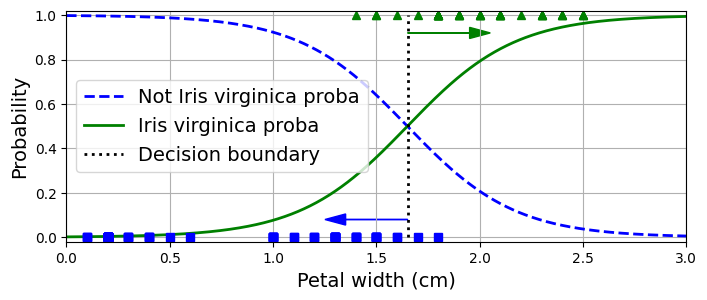

In [21]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)  # reshape to get a column vector
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

plt.figure(figsize=(8, 3))  # extra code – not needed, just formatting
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2,
         label="Decision boundary")

# extra code – this section beautifies Figure 4–23
plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="g", ec="g")
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.axis((0, 3, -0.02, 1.02))
plt.grid()

plt.show()

The petal width of *Iris virginica* flowers (represented as triangles) ranges from 1.4 cm to 2.5 cm, while the other iris flowers (represented by squares) generally have a smaller petal width, ranging from 0.1 cm to 1.8 cm. Notice that there is a bit of overlap. Above about 2 cm the classifier is highly confident that the flower is an *Iris virginica* (it outputs a high probability for that class), while below 1 cm it is highly confident that it is not an *Iris virginica* (high probability for the “Not Iris virginica” class). In between these extremes, the classifier is unsure. However, if you ask it to predict the class (using the `predict()` method rather than the `predict_proba()` method), it will return whichever class is the most likely. Therefore, there is a decision boundary at around 1.6 cm where both probabilities are equal to 50%: if the petal width is greater than 1.6 cm the classifier will predict that the flower is an *Iris virginica*, and otherwise it will predict that it is not (even if it is not very confident):

In [22]:
decision_boundary

np.float64(1.6516516516516517)

In [23]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

The next plot shows the same dataset, but this time displaying two features: petal width and length. Once trained, the logistic regression classifier can, based on these two features, estimate the probability that a new flower is an *Iris virginica*. The dashed line represents the points where the model estimates a 50% probability: this is the model’s decision boundary. Note that it is a linear boundary.⁠ Each parallel line represents the points where the model outputs a specific probability, from 15% (bottom left) to 90% (top right). All the flowers beyond the top-right line have over a 90% chance of being *Iris virginica*, according to the model.

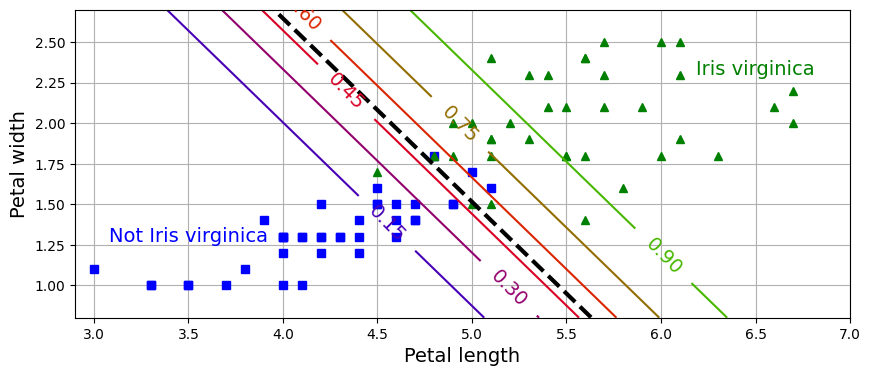

In [24]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

# for the contour plot
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]  # one instance per point on the figure
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

# for the decision boundary
left_right = np.array([2.9, 7])
boundary = -((log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0])
             / log_reg.coef_[0, 1])

plt.figure(figsize=(10, 4))
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis((2.9, 7, 0.8, 2.7))
plt.grid()

plt.show()

**Note**: The hyperparameter controlling the regularization strength of a Scikit-Learn `LogisticRegression` model is not `alpha` (as in other linear models), but its inverse: `C`. The higher the value of `C`, the less the model is regularized.

Just like the other linear models, logistic regression models can be regularized using $L1$ or $L2$ penalties. Scikit-Learn actually adds an $L2$ penalty by default.

#### 3.1.3.4 Softmax Regression

The logistic regression model can be generalized to support multiple classes directly, without having to train and combine multiple binary classifiers. This is called *softmax regression*, or *multinomial logistic regression*.

The idea is simple: when given an instance $\mathbf{x}$, the softmax regression model first computes a score $s_k(\mathbf{x})$ for each class $k$, then estimates the probability of each class by applying the *softmax function* (also called the *normalized exponential*) to the scores. The equation to compute $s_k(\mathbf{x})$ should look familiar, as it is just like the equation for linear regression prediction:

**Equation 10: Softmax score for class $k$**

$$ s_k(\mathbf{x}) = \left( \boldsymbol{\theta}^{(k)} \right) ^T \mathbf{x} $$

Note that each class has its own dedicated parameter vector $\boldsymbol{\theta}^{(k)}$. All these vectors are typically stored as rows in a parameter matrix $\boldsymbol{\Theta}$.

Once you have computed the score of every class for the instance x, you can estimate the probability $\hat{p}_k(\mathbf{x})$ that the instance belongs to class $k$ by running the scores through the softmax function. The function computes the exponential of every score, then normalizes them (dividing by the sum of all the exponentials). The scores are generally called logits or log-odds (although they are actually unnormalized log-odds).

**Equation 11: Softmax function to estimate class probabilities**

$$ \hat{p}_k(\mathbf{x}) = \sigma(s(\mathbf{x}))_k = \frac{e^{s_k(\mathbf{x})}}{\sum_{j=1}^K e^{s_j(\mathbf{x})}} $$

In this equation:

* $K$ is the number of classes.
* $s(\mathbf{x})$ is the vector of all class scores for the instance $\mathbf{x}$.
* $\sigma(s(\mathbf{x}))_k$ is the estimated probability that the instance $\mathbf{x}$ belongs to class $k$, given the scores of each class for that instance.

Just like the logistic regression classifier, by default the softmax regression classifier predicts the class with the highest estimated probability (which is simply the class with the highest score).

**Equation 12: Softmax regression model prediction**:

$$ \hat{y} = \arg\max_{k} \hat{p}_k(\mathbf{x}) = \arg\max_{k} s_k(\mathbf{x}) $$

The *argmax* operator returns the value of a variable that maximizes a function. In this equation, it returns the value of $k$ that maximizes the estimated probability $\sigma(s(\mathbf{x}))_k$.

**Tip**: The softmax regression classifier predicts only one class at a time (i.e., it is multiclass, not multioutput), so it should be used only with mutually exclusive classes, such as different species of plants. You cannot use it to recognize multiple people in one picture.

Now that you know how the model estimates probabilities and makes predictions, let’s take a look at training. The objective is to have a model that estimates a high probability for the target class (and consequently a low probability for the other classes). Minimizing the cost function, called the *cross entropy*, should lead to this objective because it penalizes the model when it estimates a low probability for a target class. Cross entropy is frequently used to measure how well a set of estimated class probabilities matches the target classes.

**Equation 13: Softmax regression cost function (cross entropy) over the whole training set**:

$$\text{CrossEntropy}(\boldsymbol{\Theta}) = - \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K y_k^{(i)} \log \left ( \hat{p}_k(\mathbf{x}^{(i)}) \right )$$

In this equation, $y_k^{(i)}$ is the target probability that the $i$-th instance belongs to class $k$. In general, it is either equal to 1 or 0, depending on whether the instance belongs to the class or not.

Notice that when there are just two classes $(K = 2)$, this cost function is equivalent to the logistic regression cost function (log loss).

The gradient vector of this cost function with regard to $\boldsymbol{\theta}^{(k)}$ is given by

**Equation 14: Gradient vector of the softmax regression cost function (cross entropy)**

$$\nabla_{\boldsymbol{\theta}^{(k)}} \text{CrossEntropy} (\boldsymbol{\Theta}) = \frac{1}{m} \sum_{i=1}^m \left( \hat{p}_k(\mathbf{x}^{(i)}) - y_k^{(i)} \right) \mathbf{x}^{(i)}$$

Now you can compute the gradient vector for every class, then use gradient descent (or any other optimization algorithm) to find the parameter matrix $\boldsymbol{\Theta}$ that minimizes the cost function.

Let’s use softmax regression to classify the iris plants into all three classes. Scikit-Learn’s `LogisticRegression` classifier uses softmax regression automatically when you train it on more than two classes (assuming you use `solver="lbfgs"`, which is the default). It also applies $L2$ regularization by default, which you can control using the hyperparameter `C`: decrease `C` to increase regularization, as mentioned earlier.

In [25]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,30
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


So the next time you find an iris with petals that are 5 cm long and 2 cm wide, you can ask your model to tell you what type of iris it is, and it will answer *Iris virginica* (class 2) with 96% probability (or *Iris versicolor* with 4% probability):

In [26]:
softmax_reg.predict([[5, 2]])

array([2])

In [27]:
softmax_reg.predict_proba([[5, 2]]).round(2)

array([[0.  , 0.04, 0.96]])

The following plot shows the resulting decision boundaries, represented by the background colors. Notice that the decision boundaries between any two classes are linear. The figure also shows the probabilities for the *Iris versicolor* class, represented by the curved lines (e.g., the line labeled with 0.30 represents the 30% probability boundary). Notice that the model can predict a class that has an estimated probability below 50%. For example, at the point where all decision boundaries meet, all classes have an equal estimated probability of 33%.

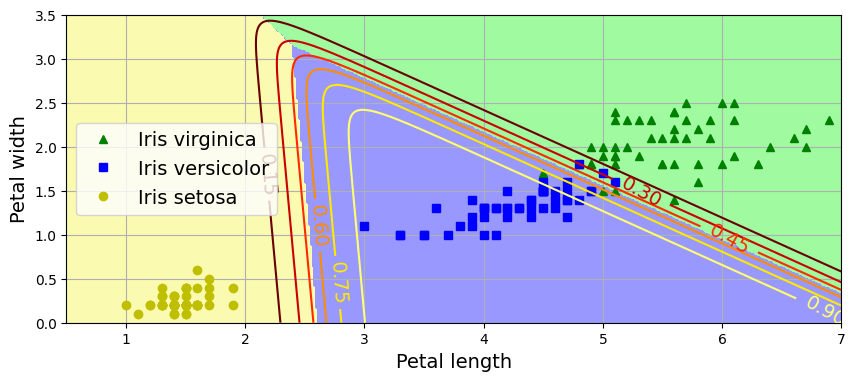

In [28]:
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis((0.5, 7, 0, 3.5))
plt.grid()

plt.show()

#### **For Further Exploration**

Check out these resources to deepen your understanding of logistic regression, gradient descent, and the bias-variance tradeoff.:

Videos:

* [StatQuest: Logistic Regression](https://youtu.be/yIYKR4sgzI8?si=7A0iQzkLAH-NAXQk)
* [Logistic Regression (and why it's different from Linear Regression)](https://youtu.be/3bvM3NyMiE0?si=UWe1nZt46QZX-r7Q)
* [Gradient Descent in 3 minutes](https://youtu.be/qg4PchTECck?si=QWwRcpG0f9nSiiWj)
* [Gradient Descent Step by step](https://youtu.be/sDv4f4s2SB8?si=kU8lVysW-2uhHY9W)
* [STOCHASTIC Gradient Descent (in 3 minutes)](https://youtu.be/UmathvAKj80?si=GLfEwxJq1yKVSn7J)
* [Stochastic Gradient Descent, Clearly Explained!!!](https://youtu.be/vMh0zPT0tLI?si=qZS2s5-PMZQCPpnk)
* [Bias and Variance](https://youtu.be/EuBBz3bI-aA?si=CWolKtysIWZaCO_8)

Google ML Crash Course Readings:
* [Gradient Descent](https://developers.google.com/machine-learning/crash-course/linear-regression/gradient-descent)
* [Hyperparameters](https://developers.google.com/machine-learning/crash-course/linear-regression/hyperparameters)
* [Logistic Regression](https://developers.google.com/machine-learning/crash-course/logistic-regression)

---
**References:**

Disclaimer: Some of the material in this notebook is adapted from other sources. These references are provided for further reading and to acknowledge the original authors.

* Chapter 4 Hands-On Machine Learning with Scikit-Learn and PyTorch by Aurélien Géron, [1st edition](https://learning.oreilly.com/library/view/hands-on-machine-learning/9798341607972/)